# DeepGL - Deep Feature Learning for graphs

We've implemented the [DeepGL](https://arxiv.org/abs/1704.08829) algorithm as a Neo4j procedure and this notebook shows our experiments with it against a SNAP email dataset.

First up let's import some things...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import pandas as pd
from neo4j.v1 import GraphDatabase
import tensorflow as tf


# load data
from sklearn.preprocessing import StandardScaler

In [18]:
driver = GraphDatabase.driver("bolt://localhost", auth=("neo4j", "neo"))

Time to load our data into Neo4j.

In [17]:
edge_list_file = "https://github.com/meltzerpete/Embedding-Vis/raw/master/emails/emails.edgelist"
labels_file = "https://github.com/meltzerpete/Embedding-Vis/raw/master/emails/emails.labels"
attributes_file = None

with driver.session() as session:
    session.run("CREATE INDEX ON :Beer(beerID)")
    session.run("CREATE INDEX ON :Beerer(beererID)")
    session.run("CREATE INDEX ON :Brewery(breweryID)")
    session.run("CREATE INDEX ON :Geocode(geocodeID)")
    
    result = session.run("""\
        LOAD CSV WITH HEADERS FROM 'https://github.com/aicfr/neo4j-openbeerdb/raw/master/beers.csv' AS row
        MERGE (b:Beer { beerID: toInteger(row.id) })
        SET b.beerName = row.name, b.description = row.descript, b.abv = toFloat(row.abv), b.label = toInteger(row.cat_id)
        """)    
    print(result.summary().counters)
    
    result = session.run("""\
    LOAD CSV WITH HEADERS FROM 'https://github.com/aicfr/neo4j-openbeerdb/raw/master/breweries.csv' AS row
    MERGE (b:Brewery { breweryID: toInteger(row.id) })
    SET b.breweryName = row.name, 
        b.address1 = row.address1, 
        b.city = row.city, 
        b.state = row.state, 
        b.zipCode = row.code, 
        b.country = row.country, 
        b.phoneNumber = row.phone, 
        b.website = row.website, 
        b.description = row.descript
    """)
    print(result.summary().counters)
    
    result = session.run("""\
    USING PERIODIC COMMIT
    LOAD CSV WITH HEADERS FROM "https://github.com/aicfr/neo4j-openbeerdb/raw/master/beers.csv" AS row
    MATCH (beer:Beer {beerID: toInteger(row.id)})
    MATCH (brewery:Brewery {breweryID: toInteger(row.brewery_id)})
    MERGE (beer)-[:BREWED_AT]->(brewery);""")
    print(result.summary().counters)
    
    result = session.run("""\
    LOAD CSV WITH HEADERS FROM 'https://github.com/aicfr/neo4j-openbeerdb/raw/master/styles.csv' AS row
    MERGE (s:Style { styleID: toInteger(row.id) })
    SET s.styleName = row.style_name""")
    print(result.summary().counters)
    
    result = session.run("""\
    USING PERIODIC COMMIT
    LOAD CSV WITH HEADERS FROM "https://github.com/aicfr/neo4j-openbeerdb/raw/master/beers.csv" AS row
    MATCH (beer:Beer {beerID: toInteger(row.id)})
    MATCH (style:Style {styleID: toInteger(row.style_id)})
    MERGE (beer)-[:BEER_STYLE]->(style)""")
    print(result.summary().counters)
    
    result = session.run("""\
    LOAD CSV WITH HEADERS FROM 'https://github.com/aicfr/neo4j-openbeerdb/raw/master/geocodes.csv' AS row
    MERGE (g:Geocode { geocodeID: toInteger(row.id) })
    SET g.latitude = toFloat(row.latitude), g.longitude = toFloat(row.longitude)""")
    print(result.summary().counters)
    
    result = session.run("""\
    USING PERIODIC COMMIT
    LOAD CSV WITH HEADERS FROM "https://github.com/aicfr/neo4j-openbeerdb/raw/master/geocodes.csv" AS row
    MATCH (brewery:Brewery {breweryID: toInteger(row.brewery_id)})
    MATCH (geocode:Geocode {geocodeID: toInteger(row.id)})
    MERGE (brewery)-[:GEOLOCATED_AT]->(geocode)""")
    print(result.summary().counters)

{'properties_set': 23604}
{'properties_set': 12726}
{}
{'properties_set': 141}
{}
{'properties_set': 2608}
{'relationships_created': 1298}


In [9]:
embedding_property_name = "embedding-beers-iter3"
node_features = []
pruning_lambda = 0.6
diffusions = 3
iterations = 3

In [15]:
with driver.session() as session:
    params = {
        "writeProperty": embedding_property_name,
        "nodeFeatures": node_features,
        "pruningLambda": pruning_lambda,
        "diffusions": diffusions,
        "iterations": iterations
    }
    result = session.run("""
    call
    algo.deepgl(
        null,
        null,
        
        {nodeFeatures: $nodeFeatures,
         pruningLambda: $pruningLambda,
         diffusions: $diffusions,
         iterations: $iterations,
         writeProperty: $writeProperty})
    """, params)
    print(result.peek())

<Record loadMillis=109 computeMillis=664679 writeMillis=760 nodes=8760 writeProperty='embedding-beers-iter3' embeddingSize=84 numberOfLayers=4 features=['l1Norm_out_neighbourhood( rbf_both_neighbourhood( diffuse( l1Norm_out_neighbourhood( IN_DEGREE))))', 'sum_out_neighbourhood( rbf_out_neighbourhood( rbf_both_neighbourhood( IN_DEGREE)))', 'diffuse( rbf_both_neighbourhood( rbf_both_neighbourhood( diffuse( l1Norm_out_neighbourhood( IN_DEGREE)))))', 'diffuse( rbf_both_neighbourhood( rbf_both_neighbourhood( diffuse( sum_in_neighbourhood( IN_DEGREE)))))', 'diffuse( rbf_both_neighbourhood( rbf_both_neighbourhood( diffuse( sum_out_neighbourhood( IN_DEGREE)))))', 'diffuse( hadamard_both_neighbourhood( rbf_out_neighbourhood( diffuse( rbf_out_neighbourhood( IN_DEGREE)))))', 'rbf_out_neighbourhood( diffuse( rbf_out_neighbourhood( IN_DEGREE)))', 'diffuse( rbf_both_neighbourhood( diffuse( rbf_in_neighbourhood( rbf_out_neighbourhood( IN_DEGREE)))))', 'diffuse( hadamard_both_neighbourhood( rbf_out_ne

In [20]:
with driver.session() as session:
    result = session.run("""\
    MATCH (n:Beer) 
    WHERE n.label <> -1 AND n.label <> 3
    WITH n.label as class, count(*) AS c
    ORDER BY c DESC
    WITH class ORDER BY class
    with collect(class) AS biggestClasses
    MATCH (p:Beer) WHERE p.label IN biggestClasses
    SET p.mlLabel = apoc.coll.indexOf(biggestClasses, p.label)
    """)

In [10]:
with driver.session() as session:
    result = session.run("""\
    MATCH (n:Beer) 
    WHERE n.label <> -1 AND n.label <> 3
    WITH n.label as class, count(*) AS c
    ORDER BY c DESC
    WITH class ORDER BY class
    with collect(class) AS biggestClasses
    MATCH (p:Beer) WHERE p.label IN biggestClasses
    RETURN p.`%s` AS embedding, apoc.coll.indexOf(biggestClasses, p.label) AS label, p.label as initialLabel, biggestClasses
    ORDER BY label
    """ % embedding_property_name)

    df = pd.DataFrame(dict(row) for row in result)

emb = df["embedding"].apply(pd.Series).values
labels = df["label"].values

/Users/markneedham/projects/Embedding-Vis/a/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


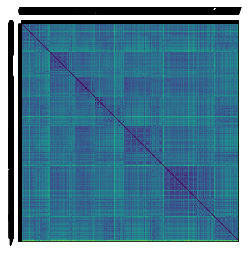

In [ ]:
# Heatmap
colours = ['r', 'g', 'b', 'black', 'y', 'orange', 'white', "beige"]
cols = pd.DataFrame(labels).apply(lambda x: colours[int(x)], axis=1).values

dist = np.ndarray([len(emb), len(emb)])

for i, e1 in enumerate(emb):
    for j, e2 in enumerate(emb):
        dist.itemset((i, j), np.linalg.norm(e1 - e2, 2))

plt.imshow(dist)
plt.axes().xaxis.tick_top()
plt.xticks(np.arange(len(dist)), labels)
plt.yticks(np.arange(len(dist)), labels)
plt.show()

# 2D Visualisation
# from: https://baoilleach.blogspot.com/2014/01/convert-distance-matrix-to-2d.html
adist = dist
amax = np.amax(adist)
adist /= amax

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)

coords = results.embedding_

plt.subplots_adjust(bottom=0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker='o', c=cols
)

plt.show()

In [ ]:
X = pd.DataFrame(emb)
y = labels

X = StandardScaler().fit_transform(X)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=.4, random_state=42)

clf = MLPClassifier(solver='sgd',
                    activation='tanh',
                    learning_rate_init=0.001,
                    alpha=1e-5,
                    hidden_layer_sizes=(30, 30),
                    max_iter=10000,
                    batch_size=X.shape[0],
                    random_state=0)

clf.n_outputs_ = 6
clf.out_activation_ = "softmax"
print(clf.get_params())
clf.fit(train_x, train_y)

mean_acc = clf.score(test_x, test_y)
print(mean_acc)

In [22]:
with driver.session() as session:
    result = session.run("""\
    MATCH (n:Beer) 
    WHERE n.label <> -1 AND n.label <> 3
    WITH n.label as class, count(*) AS c
    ORDER BY c DESC 
    with collect(class) AS biggestClasses
    MATCH (n:Node) WHERE n.label IN biggestClasses
    RETURN n.`embedding-beers-iter3` AS embedding, n.mlLabel AS label, id(n) AS nodeId
    """)
    
    for row in result:
        prediction = clf.predict(np.array([row["embedding"]]))[0]
        params = {"nodeId": row["nodeId"], "prediction": int(prediction)}
        session.run("""\
        MATCH (n) WHERE id(n) = toInteger($nodeId)
        SET n.prediction = $prediction
        """, params)


In [26]:
with driver.session() as session:
    result = session.run("""\
    MATCH (n:Beer) WHERE exists(n.mlLabel) AND n.mlLabel = n.prediction 
    WITH count(*) AS correct
    MATCH (n:Beer) WHERE exists(n.mlLabel) AND n.mlLabel <> n.prediction 
    WITH correct, count(*) AS incorrect
    RETURN correct * 1.0 / (correct + incorrect) AS accuracy
    """)
    print(result.peek())

<Record accuracy=0.8555555555555555>


In [11]:
emb = StandardScaler().fit_transform(emb)

X_train, X_test, y_train, y_test = train_test_split(emb, labels, test_size=0.33, random_state=42)

In [12]:
learning_rate = 0.1
num_steps = 1000
batch_size = 128
display_step = 100

n_hidden_1 = 30 # 1st layer number of neurons
n_hidden_2 = 30 # 2nd layer number of neurons
num_input = 18 
num_classes = 8 

def neural_net(x_dict):
    x = x_dict['emb']
    layer_1 = tf.layers.dense(x, n_hidden_1, activation=tf.nn.tanh)
    layer_2 = tf.layers.dense(layer_1, n_hidden_2, activation=tf.nn.tanh)
    out_layer = tf.layers.dense(layer_2, num_classes)
    return out_layer


def model_fn(features, labels, mode):
    logits = neural_net(features)

    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())

    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [13]:
model = tf.estimator.Estimator(model_fn)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'emb': X_train}, y=y_train,
    batch_size=batch_size, num_epochs=None, shuffle=True)

model.train(input_fn, steps=num_steps)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'emb': X_test}, y=y_test,
    batch_size=batch_size, shuffle=True)

e = model.evaluate(input_fn)

print("Testing Accuracy:", e['accuracy'])

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11c9e12b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11c9e12b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 1 into /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1 into /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt.


INFO:tensorflow:loss = 2.1635522371812224, step = 1


INFO:tensorflow:loss = 2.1635522371812224, step = 1


INFO:tensorflow:global_step/sec: 824.239


INFO:tensorflow:global_step/sec: 824.239


INFO:tensorflow:loss = 0.40319033948938265, step = 101 (0.123 sec)


INFO:tensorflow:loss = 0.40319033948938265, step = 101 (0.123 sec)


INFO:tensorflow:global_step/sec: 889.097


INFO:tensorflow:global_step/sec: 889.097


INFO:tensorflow:loss = 0.25507307173171934, step = 201 (0.112 sec)


INFO:tensorflow:loss = 0.25507307173171934, step = 201 (0.112 sec)


INFO:tensorflow:global_step/sec: 936.433


INFO:tensorflow:global_step/sec: 936.433


INFO:tensorflow:loss = 0.14379773596885312, step = 301 (0.107 sec)


INFO:tensorflow:loss = 0.14379773596885312, step = 301 (0.107 sec)


INFO:tensorflow:global_step/sec: 917.179


INFO:tensorflow:global_step/sec: 917.179


INFO:tensorflow:loss = 0.0998282147720109, step = 401 (0.110 sec)


INFO:tensorflow:loss = 0.0998282147720109, step = 401 (0.110 sec)


INFO:tensorflow:global_step/sec: 919.947


INFO:tensorflow:global_step/sec: 919.947


INFO:tensorflow:loss = 0.07226881781825856, step = 501 (0.108 sec)


INFO:tensorflow:loss = 0.07226881781825856, step = 501 (0.108 sec)


INFO:tensorflow:global_step/sec: 917.076


INFO:tensorflow:global_step/sec: 917.076


INFO:tensorflow:loss = 0.05570443809254595, step = 601 (0.109 sec)


INFO:tensorflow:loss = 0.05570443809254595, step = 601 (0.109 sec)


INFO:tensorflow:global_step/sec: 944.993


INFO:tensorflow:global_step/sec: 944.993


INFO:tensorflow:loss = 0.034553038033473996, step = 701 (0.106 sec)


INFO:tensorflow:loss = 0.034553038033473996, step = 701 (0.106 sec)


INFO:tensorflow:global_step/sec: 910.009


INFO:tensorflow:global_step/sec: 910.009


INFO:tensorflow:loss = 0.025452967130183794, step = 801 (0.110 sec)


INFO:tensorflow:loss = 0.025452967130183794, step = 801 (0.110 sec)


INFO:tensorflow:global_step/sec: 833.465


INFO:tensorflow:global_step/sec: 833.465


INFO:tensorflow:loss = 0.02703482675433859, step = 901 (0.120 sec)


INFO:tensorflow:loss = 0.02703482675433859, step = 901 (0.120 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt.


INFO:tensorflow:Loss for final step: 0.02791443447856954.


INFO:tensorflow:Loss for final step: 0.02791443447856954.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2018-07-16-11:30:31


INFO:tensorflow:Starting evaluation at 2018-07-16-11:30:31


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2018-07-16-11:30:31


INFO:tensorflow:Finished evaluation at 2018-07-16-11:30:31


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9401496, global_step = 1000, loss = 0.20630954


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9401496, global_step = 1000, loss = 0.20630954


Testing Accuracy: 0.9401496


In [ ]:
with driver.session() as session:
    result = session.run("""\
    MATCH (beer:Beer) 
    RETURN beer.beerName AS beer, beer.label AS label, beer.`embedding-beers-iter3` AS embedding, id(beer) AS nodeId
    """)
    
    for row in result:
        actual_label = row["label"]
        values_to_predict = np.array([
            row["embedding"]
        ])
        input_fn = tf.estimator.inputs.numpy_input_fn(
            x={'emb': values_to_predict},
            batch_size=batch_size, shuffle=False)

        predictions = model.predict(input_fn)
        for prediction in predictions:
            print(f"Actual: {actual_label}, Prediction: {prediction}")
            
            session.run("""\
            MATCH(b) WHERE id(b) = toInteger($nodeId)
            SET b.prediction = $prediction
            """, {"nodeId": row["nodeId"], "prediction": int(prediction)})

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 6
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 6
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 6
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 4, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 4
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 2, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 11, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 5, Prediction: 3
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 7, Prediction: 2
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 1, Prediction: 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: -1, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 8, Prediction: 5
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 1
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpp9d180t0/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Actual: 3, Prediction: 7
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.
